In [42]:
import pandas as pd
from pandas.tseries.offsets import BDay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = True
percentageOfRemovedDays = 40

In [43]:
# code for plotting and compare inside a unique chart prices and volatilities for mgarch predictions

def plot_prices_volatilities_for_mgarch(stock_prices, real_volatility, real_volatility_startDate, real_volatility_endDate, mgarchVolatility, asset_name):
    '''
    Function to plot prices and volatilities for MGARCH
    '''
     # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 11), sharex=True)

    # Plot stock prices
    ax1.plot(stock_prices[asset_name], label=f'{asset_name} Price', color='green')
    ax1.set_title(f'{asset_name} Stock Prices')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Plot real and rolling window volatilities
    ax2.plot(real_volatility_filtered, label=f'Real {asset_name} Volatility', color='blue')
    ax2.plot(mgarchVolatility, label=f'RW {asset_name} Volatility', color='orange', linestyle='--')
    ax2.set_title(f'{asset_name} Volatility: Real vs MGARCH')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility')
    ax2.legend(loc='upper left')

    # Set x-axis limits to match the start and end dates
    ax1.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    ax2.set_xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Import Data

In [44]:
stocksPrices = pd.read_csv('data/stocksPrices.csv', index_col=0, parse_dates=True)
stocksPercentageChangeReturn = pd.read_csv('data/stocksPercentageChange.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = stocksPercentageChangeReturn.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# i have 13 years of trading data; 3273 days; now i will split the dataset into 70% training, 20% validation and 10% test

total_days = len(stocksPrices)
date_70_percent = stocksPrices.index[int(total_days * 0.7)]
date_90_percent = stocksPrices.index[int(total_days * 0.9)]

# 70% training
trainingDataWithPrices = stocksPrices.loc[:date_70_percent]
trainingDataWithPercentageChange = stocksPercentageChangeReturn.loc[:date_70_percent]

# Adjust the start date for the validation set to exclude the last date of the training set
validation_start_date = date_70_percent + BDay(1)

# 20% validation
validationDataWithPrices = stocksPrices.loc[validation_start_date:date_90_percent]
validationDataWithPercentageChange = stocksPercentageChangeReturn.loc[validation_start_date:date_90_percent]

validation_end_date = validationDataWithPrices.index[-1]

# Adjust the start date for the test set to exclude the last date of the validation set
test_start_date = date_90_percent + BDay(1)

# 10% test
testDataWithPrices = stocksPrices.loc[test_start_date:]
testDataWithPercentageChange = stocksPercentageChangeReturn.loc[test_start_date:]

# print the first date and the last date of each dataset
print("First date of training dataset: ", trainingDataWithPrices.index[0])
print("Last date of training dataset: ", trainingDataWithPrices.index[-1])
print("len of training dataset: ", len(trainingDataWithPrices))

print("\nFirst date of validation dataset: ", validationDataWithPrices.index[0])
print("Last date of validation dataset: ", validationDataWithPrices.index[-1])
print("len of validation dataset: ", len(validationDataWithPrices))

print("\nFirst date of test dataset: ", testDataWithPrices.index[0])
print("Last date of test dataset: ", testDataWithPrices.index[-1])
print("len of test dataset: ", len(testDataWithPrices))

print("\ntotal dataset lenght: ", len(stocksPrices))
print("sum of the three datasets: ", len(trainingDataWithPrices) + len(validationDataWithPrices) + len(testDataWithPrices))

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272


In [45]:
print("original returns dataframe dimension: " + str(stocksPercentageChangeReturn.shape))

# Import pickle
with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

# Create a reverse mapping if necessary
ticker_to_permco = {v: k for k, v in permco_to_ticker.items()}

# Replace ticker symbols with PERMCO codes if the ticker symbol is found in the reverse mapping
columns = [ticker_to_permco.get(col, col) for col in stocksPercentageChangeReturn.columns]
stocksPercentageChangeReturn.columns = columns

# Repeat for uniformlyDistributedReturns
columns_udr = [ticker_to_permco.get(col, col) for col in uniformlyDistributedReturns.columns]
uniformlyDistributedReturns.columns = columns_udr

original returns dataframe dimension: (3272, 3)


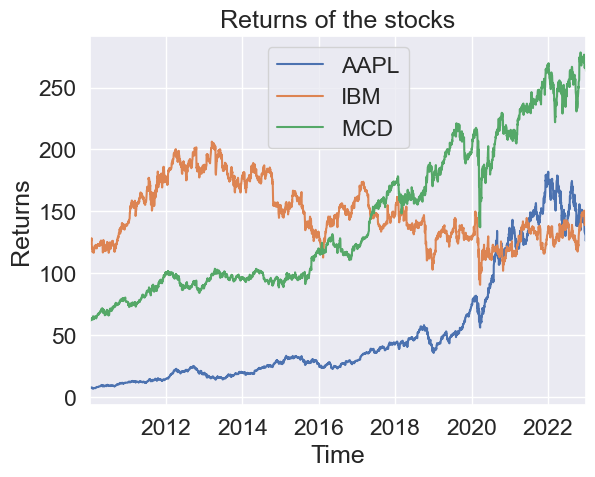

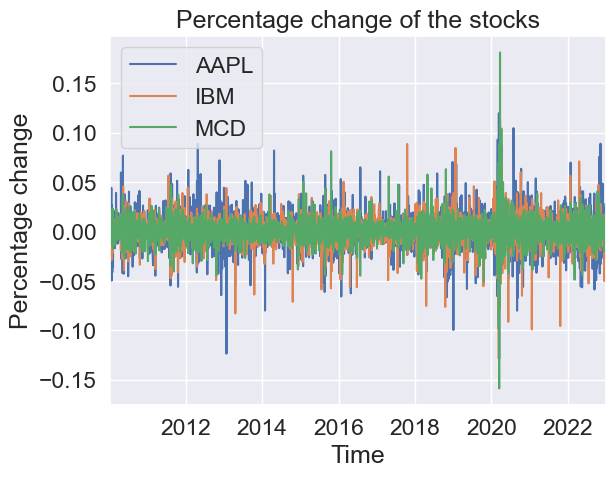

In [65]:
# plot the returns of the stocks
plt.plot(stocksPrices)

# write a legend: the green line is aapl; the blue line is ibm; the red line is mcd(this is just an example)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Returns of the stocks")
plt.xlabel("Time")
plt.ylabel("Returns")

# set x-axis limits to match the start and end dates
plt.xlim(left=stocksPrices.index[0], right=stocksPrices.index[-1])
plt.show()


# plot also the percentage change of the stocks
plt.plot(stocksPercentageChangeReturn)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Percentage change of the stocks")
plt.xlabel("Time")
plt.ylabel("Percentage change")

# set x-axis limits to match the start and end dates
plt.xlim(left=stocksPercentageChangeReturn.index[0], right=stocksPercentageChangeReturn.index[-1])
plt.show()

# Dictionary Initialization

In [47]:
prescientDict = {}
log_likelihoods = {}
regrets = {}

# create a dictionary for every predictor that saves the log-likelihoods and the regrets
log_likelihood_mgarch = {}
log_likelihood_prescient = {}

regret_mgarch = {}
regret_prescient = {}

days_greater_than_one_values = []  # To store determinant values where > 1
days_less_than_one_values = []  # To store determinant values where < 1

# Covariance Predictors

PRESCIENT(GROUND TRUTH)

In [48]:
# THIS CODE IS CALCULATING THE REAL VOLATILITY

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)

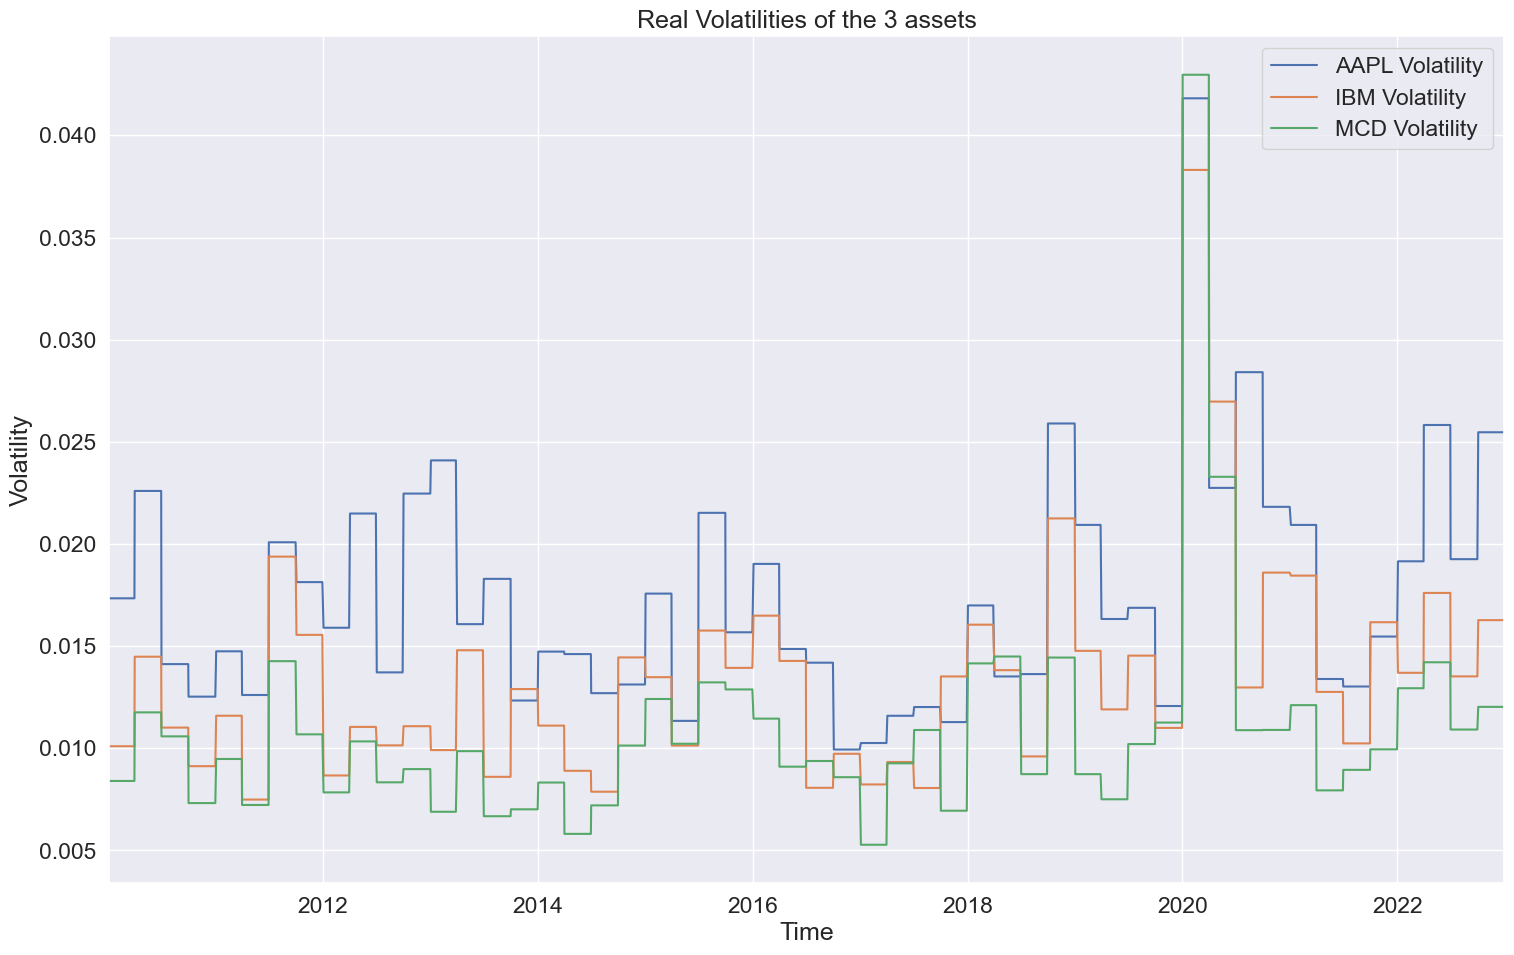

In [49]:
# THIS IS THE VISUALIZATION OF THE REAL VOLAITILITIES OF THE 3 ASSETS

# now calculates/extract the real volatilities of the 3 assets
real_volatilities = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now real_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the prescientDict dictionary(the timestamp)

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_volatilities.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD


# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Set x-axis limits to the first and last index of your time series data
plt.xlim(df_volatility_aapl.index[0], df_volatility_aapl.index[-1])

plt.show()

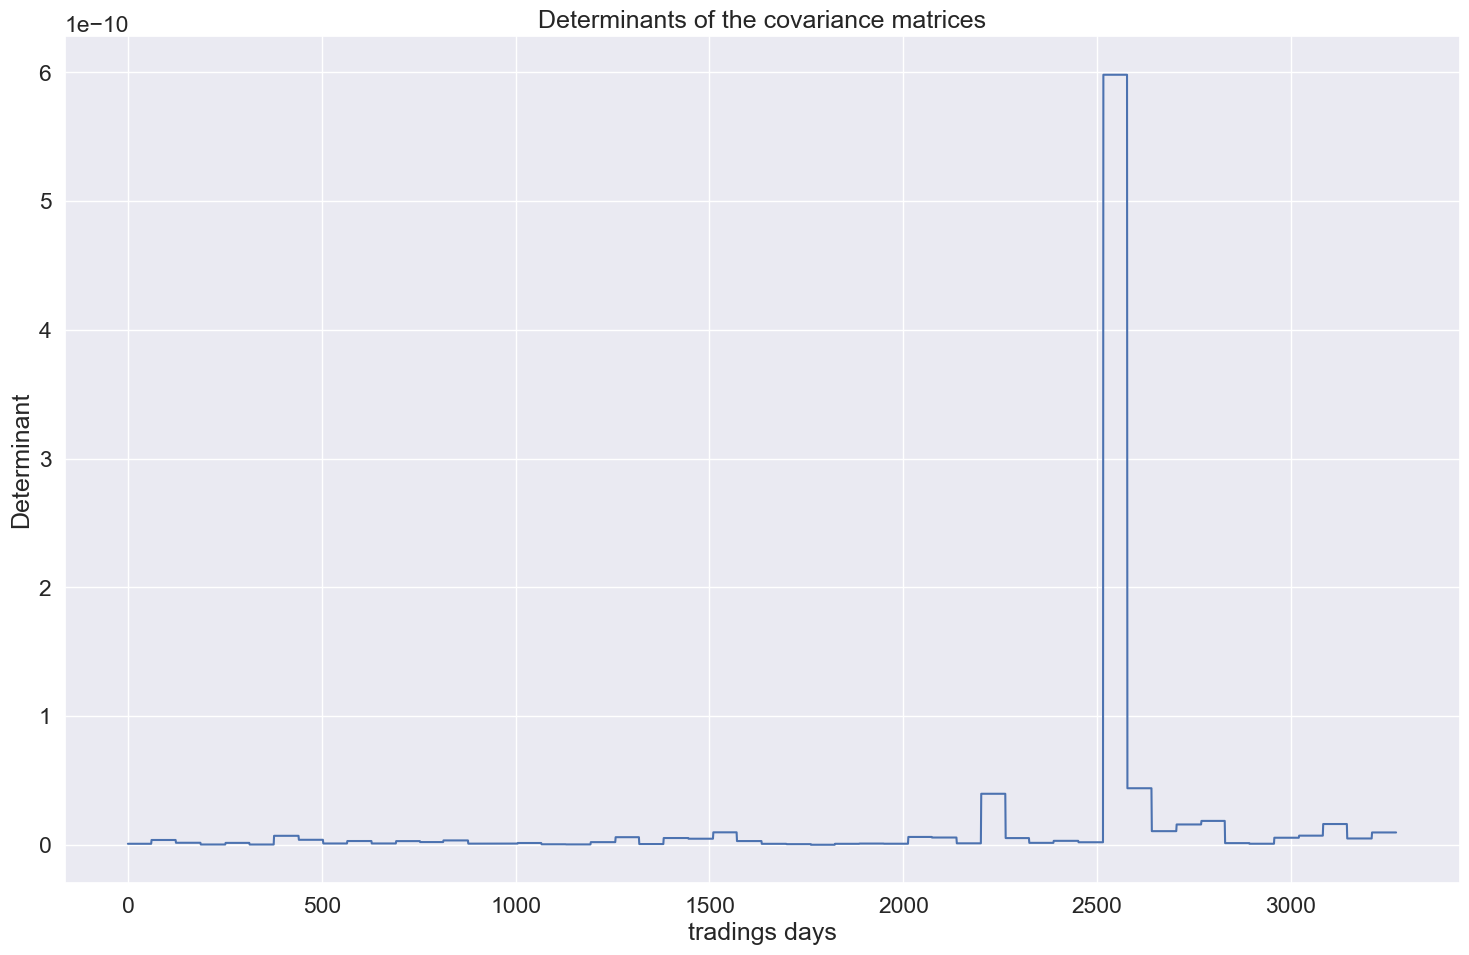

In [50]:
# HERE THERE IS A BRIEF STUDY OF THE DETERMINANTS OF THE COVARIANCE MATRICES; SO THIS EXPLAINS WHY THE LOG LIKELIHOOD OF THE PRESCIENT PREDICTOR IS POSITIVE
# this because from the chart is clear that for every trading day the determinant of the covariance matrix is lower than 1; so the log term became positive

# now let's study why the prescient predictor has a positive log-likelihood and a 0 regret: i make a list off all the determinants of the covariance matrices and i plot them
determinants = []
for date, cov_matrix in prescientDict.items():
    determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.figure(figsize=(18, 11))
plt.plot(determinants)
plt.title("Determinants of the covariance matrices")
plt.xlabel("tradings days")
plt.ylabel("Determinant")
plt.show()

FOR THE MGARCH PREDICTOR I IMPORT THE COVARIANCE MATRICES ALREDY CALCULATED; SO IT'S LIKE THE TRAINING PART HAS BEEN DONE ALREADY, AND I NEED TO VERY THAT THE PREDICTOR IS WORKING PROPERLY(SO I NEED TO VERIFY THE VALIDATION PART)

# Validation Phase for MGARCH Predictor

with the armaOrder = (10,10) and the garchOrder = (10,10) and dccorder = (10,10) the performance are worse respect the case with armaOrder = (1,1) and garchOrder = (1,1) and dccorder = (1,1) -> at the moment the best performance are with the smallest order(this because the performance are more or less equal but the number of parameters are smaller in the case with the smallest order) -> with the smallest order the number of parameters are 17; the number of parameters with the order (10,10) are 149. so i prefer the smallest order

In [51]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedCovMatricesForValidation.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
testSetLength = len(testDataWithPercentageChange)
times = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

# TODO: check the size of the dict and in case remove the test set part from the dictionary


sigma shape: (654, 3, 3)
len of times:  654
mgarchDict len: 654
2019-02-11 00:00:00
          7         20990     21177
7      0.000377  0.000080  0.000038
20990  0.000080  0.000165  0.000038
21177  0.000038  0.000038  0.000095


2021-09-14 00:00:00
          7         20990     21177
7      0.000266  0.000049  0.000023
20990  0.000049  0.000115  0.000036
21177  0.000023  0.000036  0.000074


In [52]:
# now see how well the mgarch predictor is doing in predicting the real volatilities of the 3 assets by calculating the log-likelihood and the regret and mse

# Define start and end of backtest; first two years used for training/burn-in
startingValidationDate = validationDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingValidationDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingValidationDate, format="%Y-%m-%d")

In [53]:
names = ["MGARCH", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [mgarchDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# Log Likelihoods

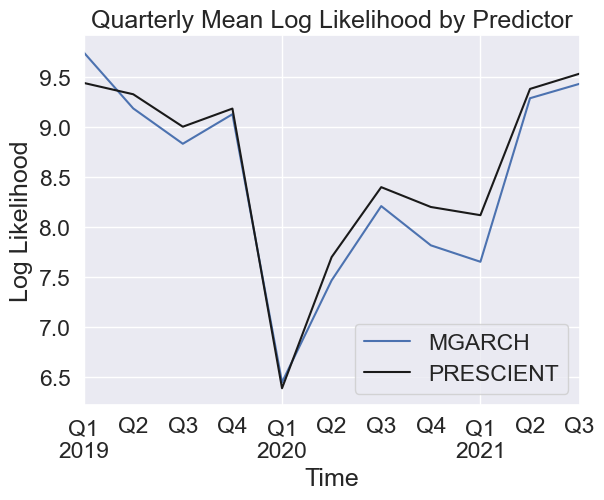



meanRegret: 0.100
stdRegret: 0.200
maxRegret: 0.500


meanLoglikelihoodMGARCH: 8.500
stdLoglikelihoodMGARCH: 1.000
maxLoglikelihoodMGARCH: 9.700


meanLoglikelihoodPRESCIENT: 8.600
stdLoglikelihoodPRESCIENT: 0.900
maxLoglikelihoodPRESCIENT: 9.500

MGARCH MSE: 
mean: 0.0000121651
std: 0.0000331323
max: 0.0001115467


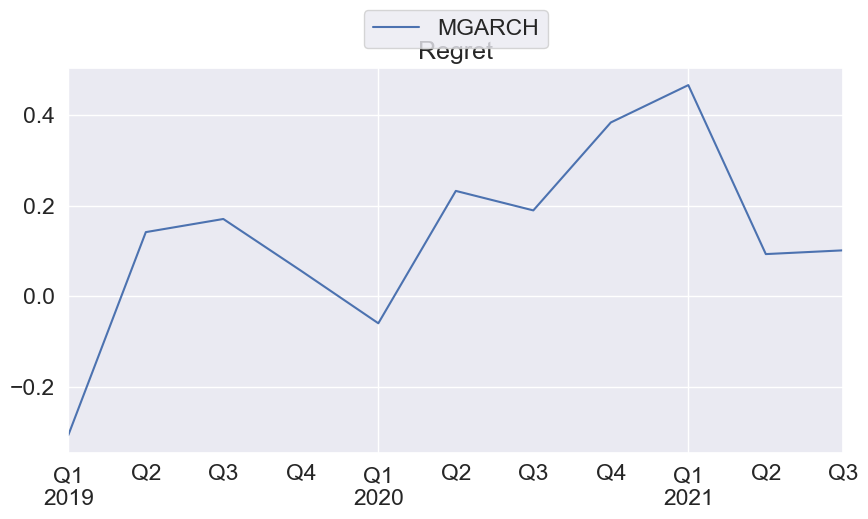

In [54]:
'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot


'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.title("Regret")


for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # TODO: save the regret mean values to plot a chart

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")

#
# MSEs
#

for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(stocksPercentageChangeReturn, predictorDict).resample("Q").mean()

        print("\n" + names[i] + " MSE: ")
        print(f"mean: {MSE_temp.mean():.10f}")
        print(f"std: {MSE_temp.std():.10f}")
        print(f"max: {MSE_temp.max():.10f}")

sigma shape: (654, 3, 3)
len of times:  654
mgarchDict len: 654
2019-02-11 00:00:00
          7         20990     21177
7      0.000377  0.000080  0.000038
20990  0.000080  0.000165  0.000038
21177  0.000038  0.000038  0.000095


2021-09-14 00:00:00
          7         20990     21177
7      0.000266  0.000049  0.000023
20990  0.000049  0.000115  0.000036
21177  0.000023  0.000036  0.000074


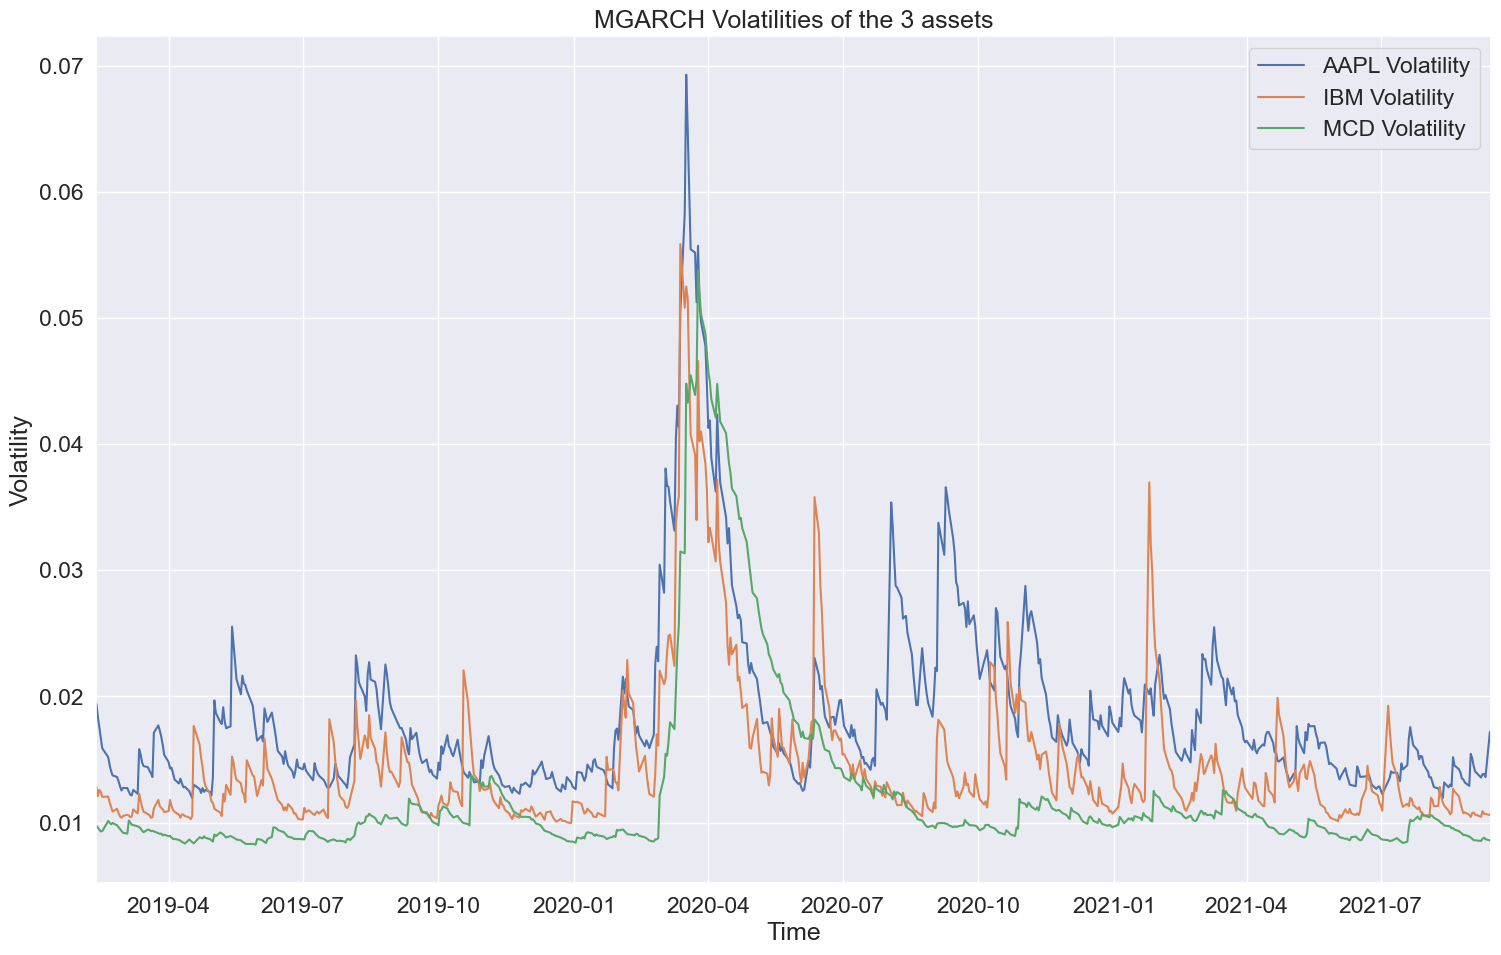

In [55]:
# prepare the date for the test phase
startingTestDate = validationDataWithPrices.index[0].strftime("%Y-%m-%d")
endingTestDate = validationDataWithPrices.index[-1].strftime("%Y-%m-%d")

# read from this file the covariance matrices calculated for the test phase
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedCovMatricesForValidation.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
testSetLength = len(testDataWithPercentageChange)
times = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# calculate the covariance matrix for the test phase

# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

mgarch_volatilities = {}

for date, cov_matrix in mgarchDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    mgarch_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now mgarch_volatilities is a dictionary that contains the volatilities of the 3 assets for every day with the same key of the mgarchDict dictionary(the timestamp)
    
# now separate the volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl_mgarch = {}
volatility_dict_ibm_mgarch = {}
volatility_dict_mcd_mgarch = {}

for date, volatilities in mgarch_volatilities.items():
    volatility_dict_aapl_mgarch[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm_mgarch[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd_mgarch[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl_mgarch = pd.DataFrame(list(volatility_dict_aapl_mgarch.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm_mgarch = pd.DataFrame(list(volatility_dict_ibm_mgarch.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd_mgarch = pd.DataFrame(list(volatility_dict_mcd_mgarch.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl_mgarch.set_index('Date', inplace=True)
df_volatility_ibm_mgarch.set_index('Date', inplace=True)
df_volatility_mcd_mgarch.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl_mgarch, label='AAPL Volatility')
plt.plot(df_volatility_ibm_mgarch, label='IBM Volatility')
plt.plot(df_volatility_mcd_mgarch, label='MCD Volatility')
plt.legend()
plt.title("MGARCH Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Set x-axis limits to the first and last index of your time series data
plt.xlim(df_volatility_aapl_mgarch.index[0], df_volatility_aapl_mgarch.index[-1])
plt.show()

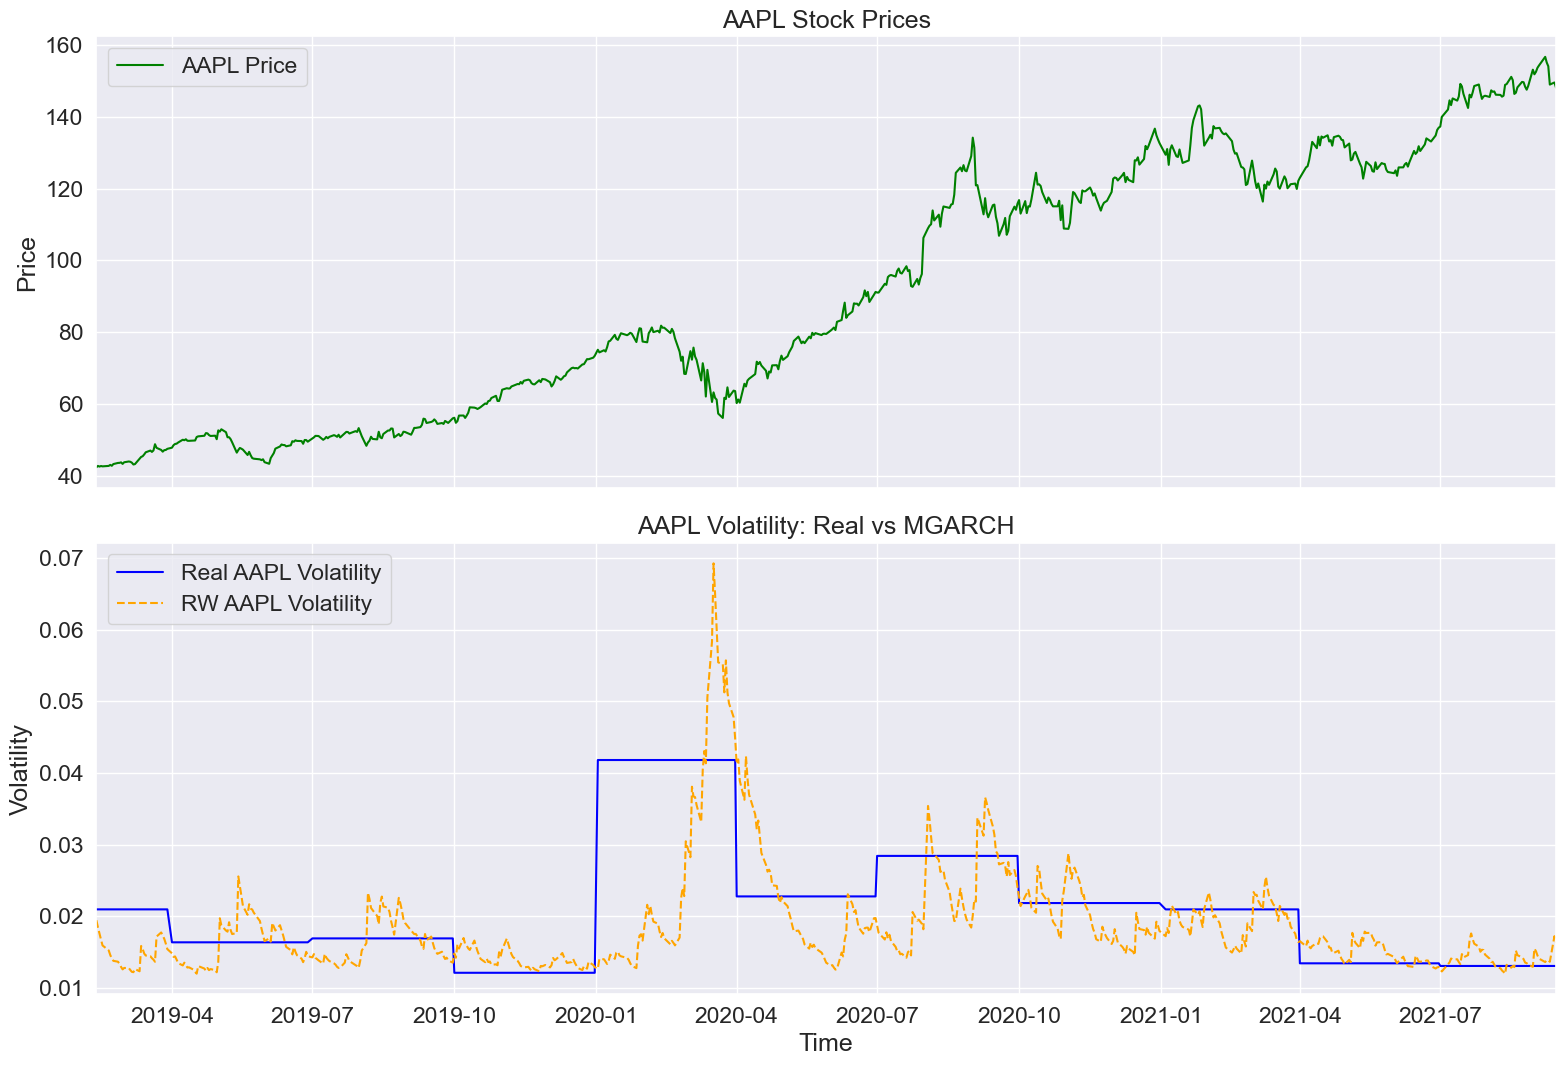

In [56]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_mgarch(validationDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_mgarch['AAPL Volatility'], 'AAPL')

# Test Phase for MGARCH predictor

In this test phase i will use the best Mgarch model found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

sigma shape: (327, 3, 3)
len of times:  327
mgarchDict len: 327
2021-09-15 00:00:00
          7         20990     21177
7      0.000253  0.000056  0.000024
20990  0.000056  0.000132  0.000037
21177  0.000024  0.000037  0.000072


2022-12-30 00:00:00
          7         20990     21177
7      0.000435  0.000121  0.000074
20990  0.000121  0.000159  0.000047
21177  0.000074  0.000047  0.000088


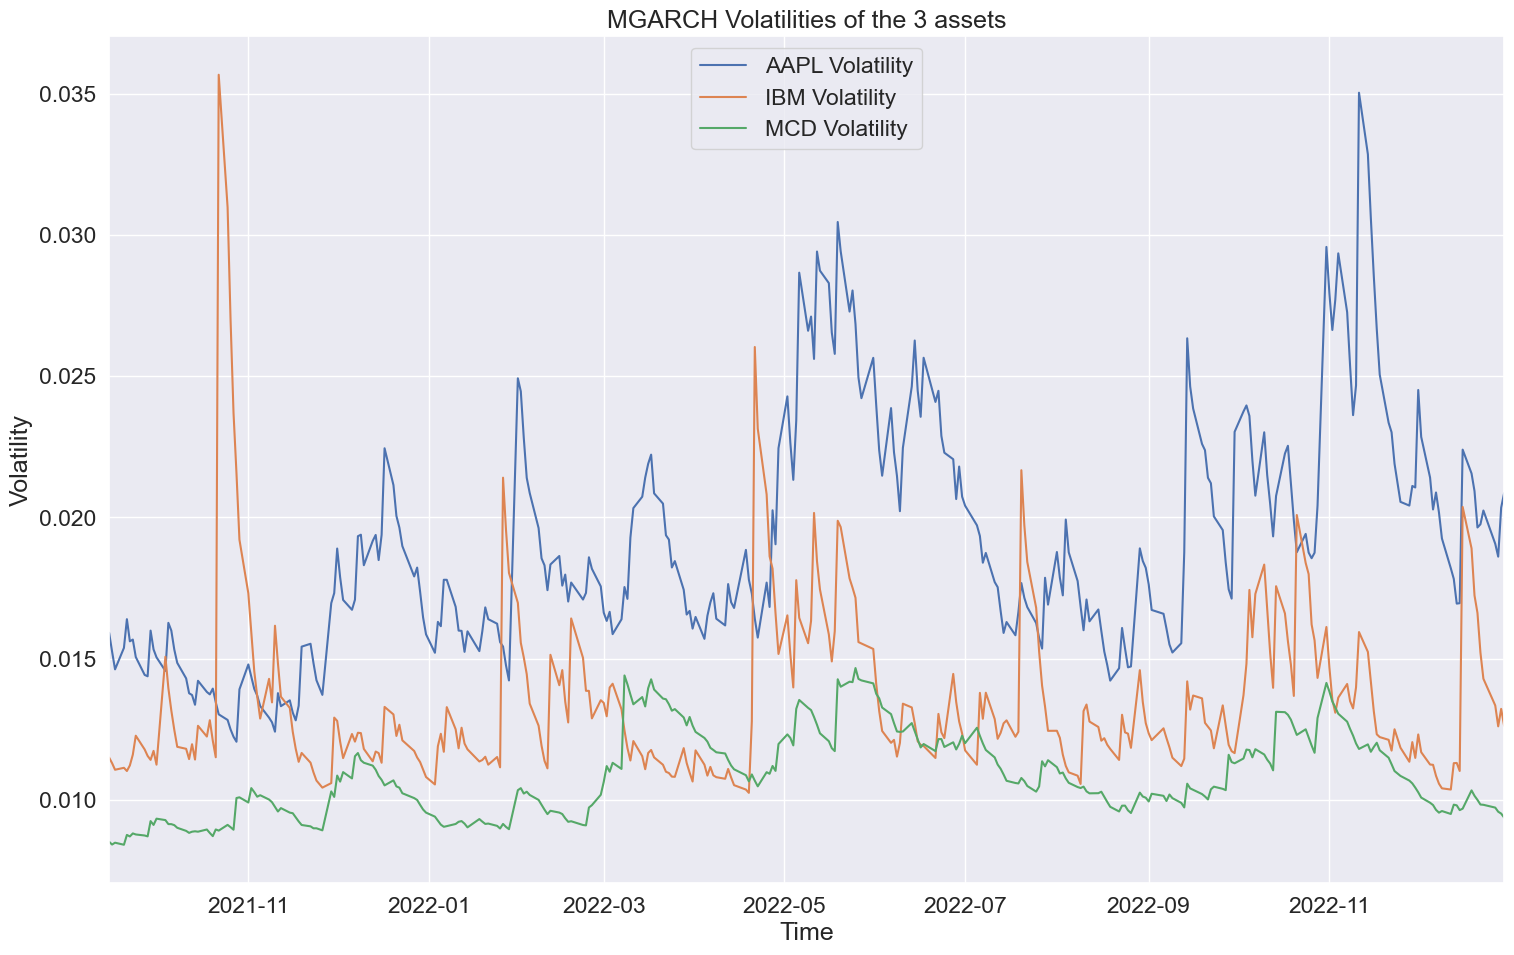

In [57]:
# prepare the date for the test phase
startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# read from this file the covariance matrices calculated for the test phase
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedCovMatricesForTesting.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
validationSetLength = len(validationDataWithPercentageChange)
times = stocksPercentageChangeReturn.index[trainingSetLength + validationSetLength:]

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# calculate the covariance matrix for the test phase

# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

mgarch_volatilities = {}

for date, cov_matrix in mgarchDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    mgarch_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now mgarch_volatilities is a dictionary that contains the volatilities of the 3 assets for every day with the same key of the mgarchDict dictionary(the timestamp)
    
# now separate the volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl_mgarch = {}
volatility_dict_ibm_mgarch = {}
volatility_dict_mcd_mgarch = {}

for date, volatilities in mgarch_volatilities.items():
    volatility_dict_aapl_mgarch[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm_mgarch[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd_mgarch[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl_mgarch = pd.DataFrame(list(volatility_dict_aapl_mgarch.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm_mgarch = pd.DataFrame(list(volatility_dict_ibm_mgarch.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd_mgarch = pd.DataFrame(list(volatility_dict_mcd_mgarch.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl_mgarch.set_index('Date', inplace=True)
df_volatility_ibm_mgarch.set_index('Date', inplace=True)
df_volatility_mcd_mgarch.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl_mgarch, label='AAPL Volatility')
plt.plot(df_volatility_ibm_mgarch, label='IBM Volatility')
plt.plot(df_volatility_mcd_mgarch, label='MCD Volatility')
plt.legend()
plt.title("MGARCH Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")

# Set x-axis limits to the first and last index of your time series data
plt.xlim(df_volatility_aapl_mgarch.index[0], df_volatility_aapl_mgarch.index[-1])
plt.show()

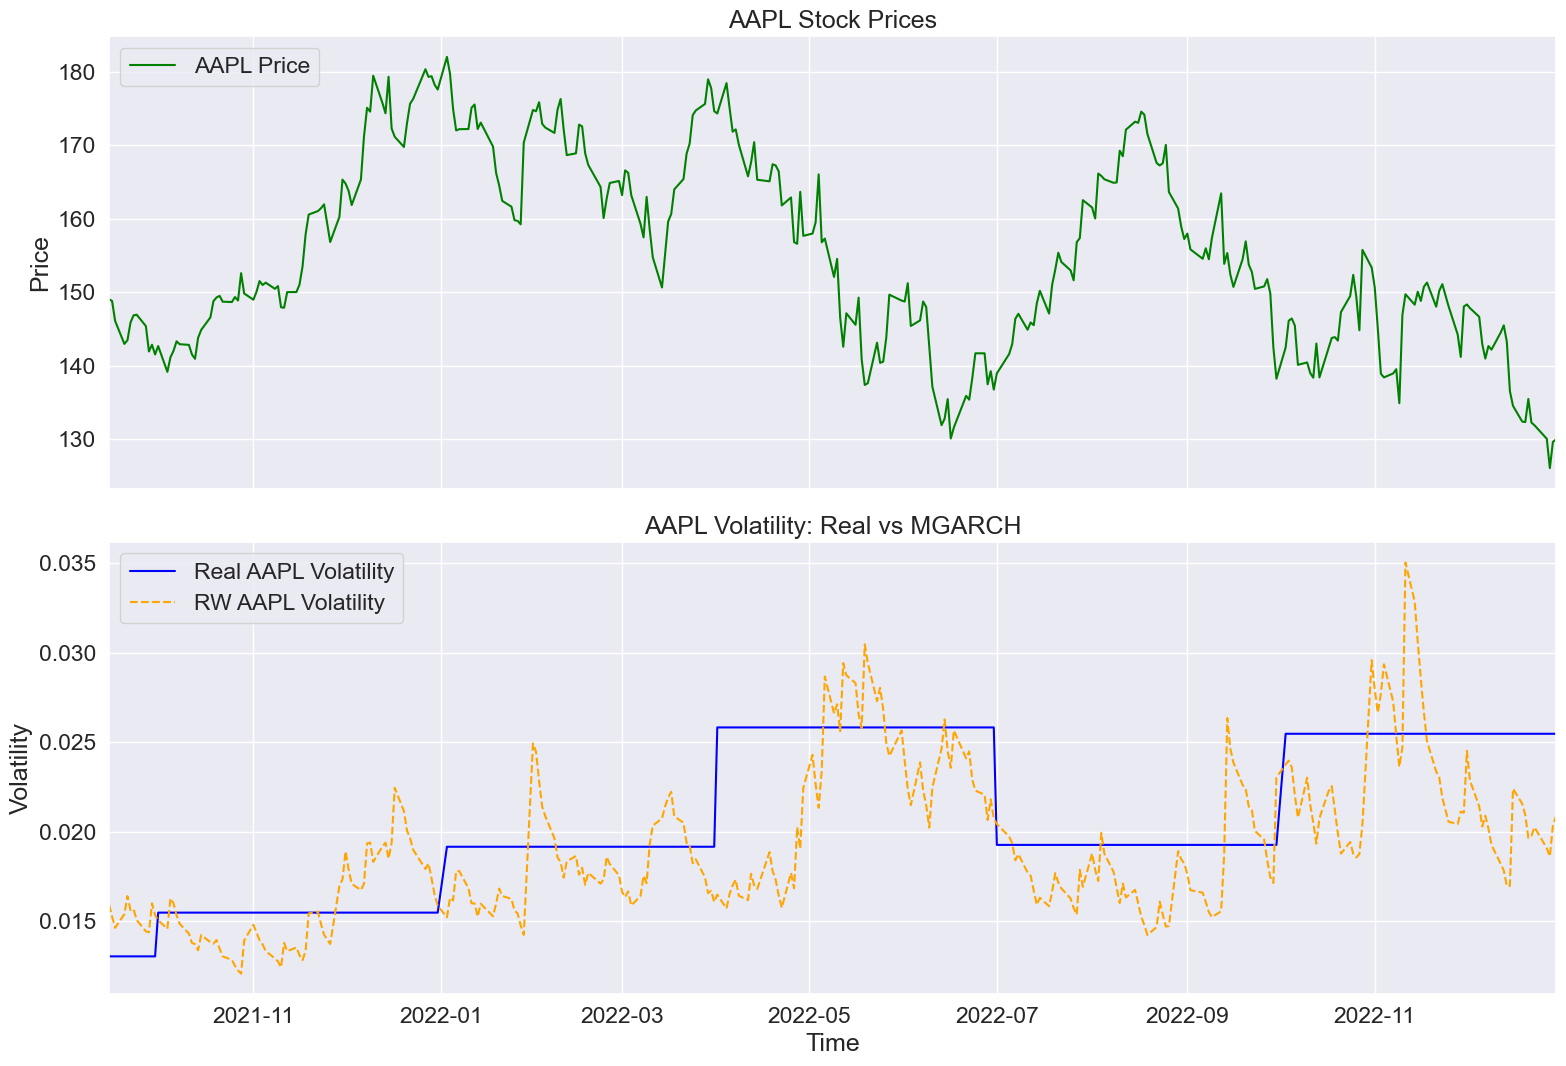

In [58]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_mgarch(testDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_mgarch['AAPL Volatility'], 'AAPL')

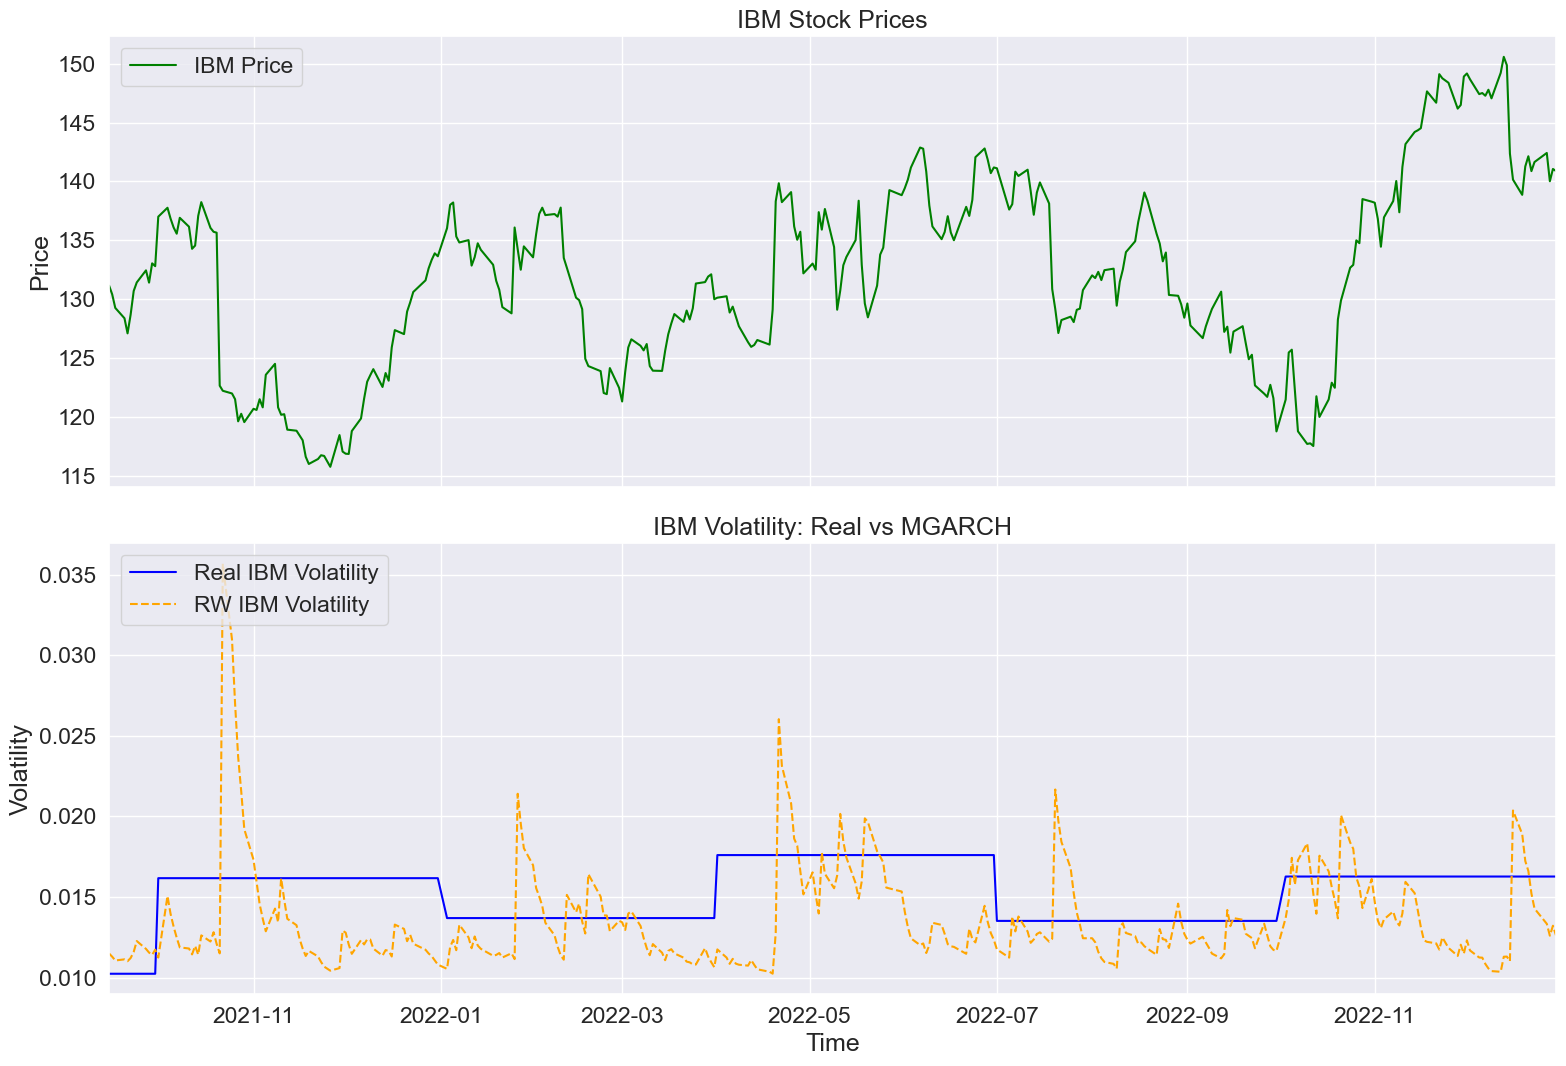

In [59]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_mgarch(testDataWithPrices, df_volatility_ibm["IBM Volatility"], startDateFilter, endDateFilter, df_volatility_ibm_mgarch['IBM Volatility'], 'IBM')

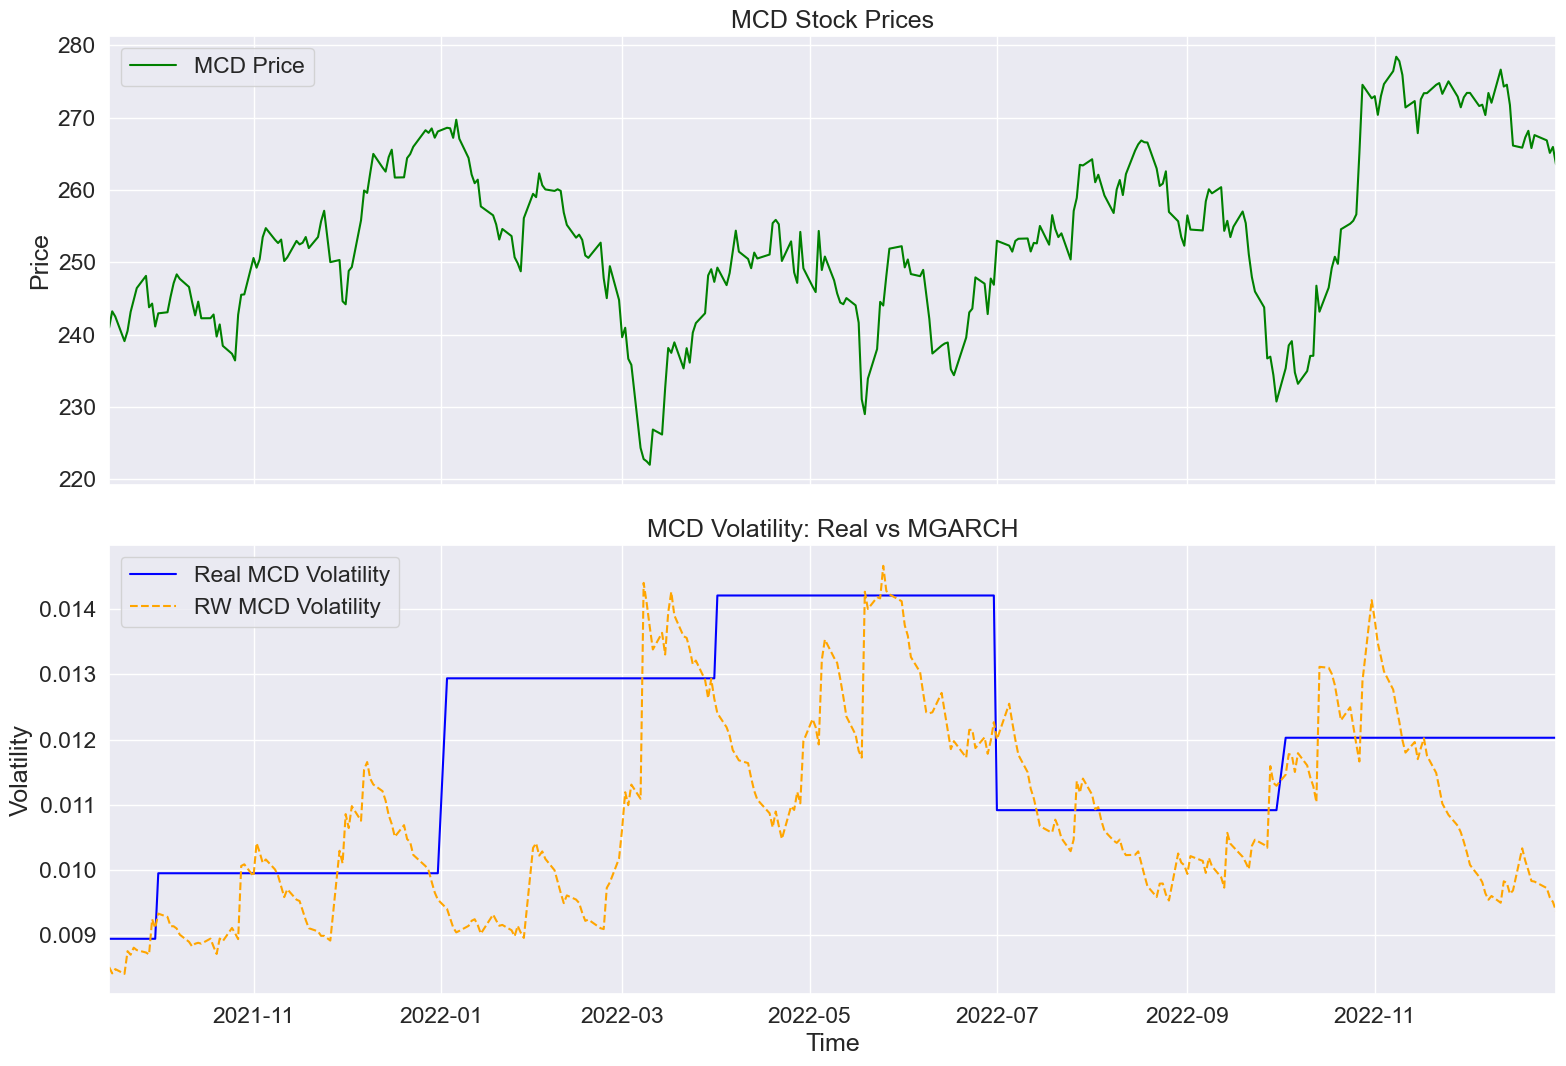

In [60]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_mgarch(testDataWithPrices, df_volatility_mcd["MCD Volatility"], startDateFilter, endDateFilter, df_volatility_mcd_mgarch['MCD Volatility'], 'MCD')

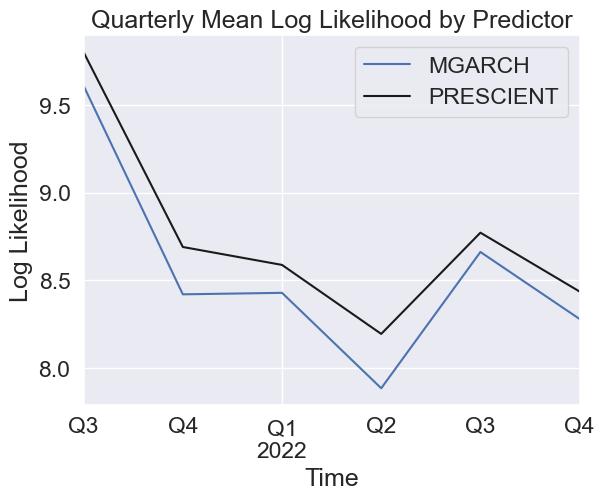



meanRegret: 0.200
stdRegret: 0.100
maxRegret: 0.300


meanLoglikelihoodMGARCH: 8.500
stdLoglikelihoodMGARCH: 0.500
maxLoglikelihoodMGARCH: 9.600


meanLoglikelihoodPRESCIENT: 8.700
stdLoglikelihoodPRESCIENT: 0.500
maxLoglikelihoodPRESCIENT: 9.800

MGARCH MSE
mean: 0.0000015838
std: 0.0000010487
max: 0.0000031643


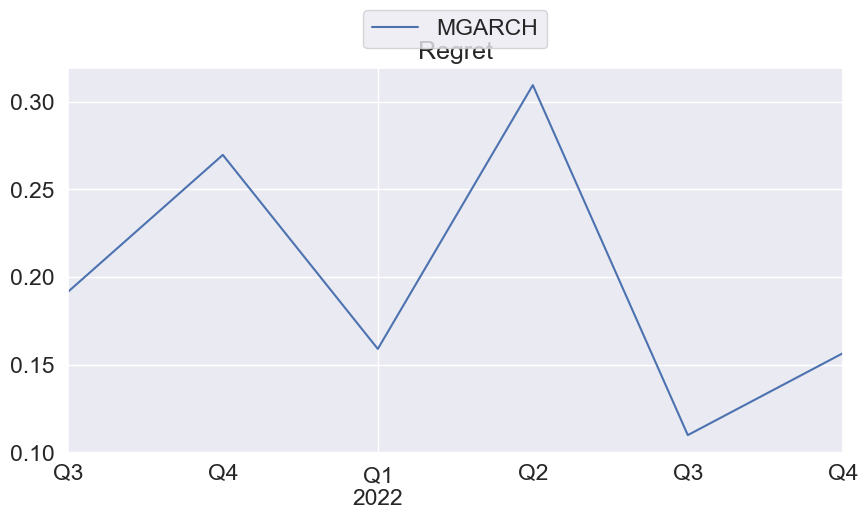

In [61]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE MGARCH PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["MGARCH", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [mgarchDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot


'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.title("Regret")


for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,


print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# MSEs
#

for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(stocksPercentageChangeReturn, predictorDict).resample("Q").mean()

        print("\n" + names[i] + " MSE")
        print(f"mean: {MSE_temp.mean():.10f}")
        print(f"std: {MSE_temp.std():.10f}")
        print(f"max: {MSE_temp.max():.10f}")